# Capstone - Loan Status Prediction Machine Learning Model

**Goal**: Build machine learning model(s) to predict loan status as target: if a loan will be charged-off (1), or stay current/are paid off (0). 

##  Import packages

In [1]:
# Install packages
# import sys
# !{sys.executable} -m pip install kneed

# Get path 
import os
from pathlib import Path # get path

# Data wrangling
import pandas as pd
import numpy as np 
import math


# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot # qqplot for data normality test

# Statistical testing
import scipy.stats as stats


# Reporting
from pandas_profiling import ProfileReport


# PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


#ML model building

# Logistic regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from dmba import classificationSummary

no display found. Using non-interactive Agg backend


## Load dataset¶

In [2]:
# load datasets
data_path_train = Path('.').resolve().parents[1] / 'train_data.csv'
train = pd.read_csv(data_path_train)
data_path_test = Path('.').resolve().parents[1] / 'updated_test_data_20200728.csv'
test = pd.read_csv(data_path_test)

/var/folders/d5/0rs5hy6j79776c7g000ncxbm0000gn/T/ipykernel_22046/539946901.py:3: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(data_path_train)


In [98]:
test_copy = test.copy()

In [3]:
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')
print(f'extra column from test to remove: {[i for i in test.columns.tolist() if i not in train.columns.tolist()]}')

# Remove extra colummn
tst = test.copy().drop(columns='index')
tst.shape

train shape: (1827125, 145)
test shape: (211627, 146)
extra column from test to remove: ['index']


(211627, 145)

In [4]:
tst['loan_status'].unique()

array([nan])

In [5]:
tst['collection_recovery_fee'].unique()
tst['out_prncp_inv'].unique()
tst['recoveries'].isna().sum()
tst['out_prncp'].isna().sum()

211627

test dataset:
- loan_status to be filled in by test results
- collection_recovery_fee, out_prncp_inv, 'out_prncp', 'recoveries', are empty in test not train

# Prepare dataset

Train from EDA. and remove ['emp_length','addr_state','sub_grade','all_util','mths_since_last_delinq']

In [10]:
df_test = tst

#########
na_tally = df_test.isna().sum().sort_values(ascending = False)
df_test = df_test.drop(columns=na_tally[na_tally>df_test.shape[0]*0.9].index)
    ###
col_types = df_test.dtypes.to_frame('dtypes').reset_index()
coln_obj = col_types[col_types['dtypes']=='O']['index'] 
coln_obj_drop = [i for i in coln_obj.tolist() if i not in ['term', 'grade', 'sub_grade', 'debt_settlement_flag', 'emp_length', 'purpose', 'addr_state',
                                                           'issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']]
df_dropEDA = df_test.copy().drop(columns=coln_obj_drop+['policy_code', 'funded_amnt', 'funded_amnt_inv', 'total_pymnt_inv']+['installment', 'open_acc', 'total_rec_prncp', 'tot_cur_bal', 'total_bal_il', 'num_actv_rev_tl'])
    ###
df_dropEDA_date = pd.to_datetime(df_dropEDA[['earliest_cr_line', 'last_credit_pull_d']].stack(), infer_datetime_format=True).unstack()
    # add to dropEDA set
df_dropEDA_time = df_dropEDA.copy()
df_dropEDA_time['cr_dur_yr'] = ((df_dropEDA_date['last_credit_pull_d'] - df_dropEDA_date['earliest_cr_line'])/pd.Timedelta('365 days')).astype(float)
time_drop = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d'] + ['mo_sin_rcnt_rev_tl_op',
                                                                                                     'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_rcnt_il', 'mths_since_last_record', 'mths_since_recent_inq']
df_dropEDA_time = df_dropEDA_time.drop(columns=time_drop)
df_dropEDA_time_imp = df_dropEDA_time.drop(columns=['pct_tl_nvr_dlq', 'bc_open_to_buy', 'inq_fi', 'inq_last_12m', 'num_rev_accts', 'num_tl_120dpd_2m', 'percent_bc_gt_75',
                      'open_acc_6m', 'open_rv_12m', 'open_il_24m', 'open_il_12m', 'open_act_il', 'open_rv_24m', 'total_cu_tl', 'il_util', 'bc_util','max_bal_bc','mo_sin_old_il_acct','mths_since_recent_revol_delinq','mths_since_recent_bc_dlq','mths_since_last_major_derog','avg_cur_bal'])
### Drop 
df_dropEDA_time_imp = df_dropEDA_time_imp.drop(columns=['emp_length','addr_state','sub_grade','all_util','mths_since_last_delinq'])
######

test_ML = df_dropEDA_time_imp

In [11]:
df_train = train.copy()

#########
na_tally = df_train.isna().sum().sort_values(ascending = False)
df_train = df_train.drop(columns=na_tally[na_tally>df_train.shape[0]*0.9].index)
df_train['loan_status_dv'] = [0 if loan_status=='Fully Paid' or loan_status=='Current' else 1 for loan_status in df_train['loan_status']]
    ###
col_types = df_train.dtypes.to_frame('dtypes').reset_index()
coln_obj = col_types[col_types['dtypes']=='O']['index'] 
coln_obj_drop = [i for i in coln_obj.tolist() if i not in ['term', 'grade', 'sub_grade', 'debt_settlement_flag', 'emp_length', 'purpose', 'addr_state',
                                                           'issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']]
df_dropEDA = df_train.copy().drop(columns=coln_obj_drop+['policy_code', 'funded_amnt', 'funded_amnt_inv', 'out_prncp_inv', 'total_pymnt_inv']+['installment', 'open_acc', 'total_rec_prncp', 'collection_recovery_fee', 'tot_cur_bal', 'total_bal_il', 'num_actv_rev_tl'])
    ###
df_dropEDA_date = pd.to_datetime(df_dropEDA[['earliest_cr_line', 'last_credit_pull_d']].stack(), infer_datetime_format=True).unstack()
    # add to dropEDA set
df_dropEDA_time = df_dropEDA.copy()
df_dropEDA_time['cr_dur_yr'] = ((df_dropEDA_date['last_credit_pull_d'] - df_dropEDA_date['earliest_cr_line'])/pd.Timedelta('365 days')).astype(float)
time_drop = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d'] + ['mo_sin_rcnt_rev_tl_op',
                                                                                                     'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_rcnt_il', 'mths_since_last_record', 'mths_since_recent_inq']
df_dropEDA_time = df_dropEDA_time.drop(columns=time_drop)
df_dropEDA_time_imp = df_dropEDA_time.drop(columns=['pct_tl_nvr_dlq', 'bc_open_to_buy', 'inq_fi', 'inq_last_12m', 'num_rev_accts', 'num_tl_120dpd_2m', 'percent_bc_gt_75',
                      'open_acc_6m', 'open_rv_12m', 'open_il_24m', 'open_il_12m', 'open_act_il', 'open_rv_24m', 'total_cu_tl', 'il_util', 'bc_util','max_bal_bc','mo_sin_old_il_acct','mths_since_recent_revol_delinq','mths_since_recent_bc_dlq','mths_since_last_major_derog','avg_cur_bal'])
#### Drop
df_dropEDA_time_imp = df_dropEDA_time_imp.drop(columns=['emp_length','addr_state','sub_grade','all_util','mths_since_last_delinq'])
######

train_ML = df_dropEDA_time_imp

In [12]:
train_ML.isna().sum()[train_ML.isna().sum().sort_values(ascending=False) > 0]

dti               1451
inq_last_6mths       1
revol_util        1414
dtype: int64

In [13]:
test_ML.isna().sum()[test_ML.isna().sum().sort_values(ascending=False) > 0]

dti           178
revol_util    153
dtype: int64

In [15]:
# Impute dti 
train[train['dti'].isna()].index # get index with missing dti
train_ML.loc[train[train['dti'].isna()].index, 'dti'] = train[train['dti'].isna()]['dti_joint'].values

test[test['dti'].isna()].index # get index with missing dti
test_ML.loc[test[test['dti'].isna()].index, 'dti'] = test[test['dti'].isna()]['dti_joint'].values

# Impute inq_last_6mthsinquiries 
train_ML.loc[train_ML[train_ML['inq_last_6mths'].isna()].index, 'inq_last_6mths'] = math.ceil(train_ML['inq_last_6mths'].mean()) # Impute to 1


# Impute revol_util 
train_ML.loc[train_ML[train_ML['revol_util'].isna()].index, 'revol_util'] = train_ML['revol_util'].mean() 
test_ML.loc[test_ML[test_ML['revol_util'].isna()].index, 'revol_util'] = test_ML['revol_util'].mean() 

In [16]:
train_ML.isna().sum()[train_ML.isna().sum().sort_values(ascending=False) > 0]

Series([], dtype: int64)

In [17]:
test_ML.isna().sum()[test_ML.isna().sum().sort_values(ascending=False) > 0]

Series([], dtype: int64)

## Check if two dataset has same columns
Remove 'out_prncp', 'recoveries' in train_ML

In [18]:
[i for i in train_ML.columns.tolist() if i not in test_ML.columns.tolist()]

['out_prncp', 'recoveries', 'loan_status_dv']

In [19]:
[i for i in test_ML.columns.tolist() if i not in train_ML.columns.tolist()]

[]

In [20]:
train_ML = train_ML.drop(columns=['out_prncp', 'recoveries'])

In [23]:
print(f'test_ML features: {test_ML.shape[1]}')
print(f'train_ML features: {train_ML.shape[1]}')

test_ML features: 45
train_ML features: 46


In [22]:
#test_ML.to_csv('test_ML.csv')
#train_ML.to_csv('train_ML.csv')

# Logistic Regression - base

test_ML_p = Path('.').resolve().parents[1] / 'test_ML.csv'
train_ML_p = Path('.').resolve().parents[1] / 'train_ML.csv'

train_ML = pd.read_csv(train_ML_p)
test_ML = pd.read_csv(test_ML_p)

In [111]:
print(f'test_ML features: {test_ML.shape[1]}')
print(f'train_ML features: {train_ML.shape[1]}')

test_ML features: 45
train_ML features: 46


## Define helper functions

In [43]:
def df_trn(df_train, df_test, features_drop=[]):
    '''
    One hot encoding and preparing dataset for training:
    
    df_train: dataset to be trained with features vetted
    df_test: test dataset
    features.
    features_drop: features to be dropped.
    '''
    train_ML=df_train.drop(columns=features_drop)
    
    ##### One-hot for training set #####
    trn_obj = train_ML.select_dtypes(include=['object'])
    # One-hot encode the non-numeric columns
    trn_onehot = pd.get_dummies(trn_obj, drop_first=True)

    # Union the one-hot encoded columns to the numeric ones
    trn_prep = pd.concat([train_ML.select_dtypes(exclude=['object']), trn_onehot], axis=1)

    
    test_ML=df_test.drop(columns=features_drop)
    ##### One-hot for test dataset #####
    tst_obj = test_ML.select_dtypes(include=['object'])  
    # One-hot encode the non-numeric columns
    tst_onehot = pd.get_dummies(tst_obj, drop_first=True)

    # Union the one-hot encoded columns to the numeric ones
    tst_prep = pd.concat([test_ML.select_dtypes(exclude=['object']), tst_onehot], axis=1)
    
    
    # Drop extra redundant features in tst_prep such as 'loan_status' to make sure training set use the same dimension
    trn_X=trn_prep.drop(columns=[i for i in trn_prep if i not in tst_prep])
    
    return trn_X, tst_prep

In [52]:
def score(lr, v_val, v_pred):
    '''
    Scoring function given input of v_val and v_pred and logistic regression used.
    '''
    # Score
    AUC_score = roc_auc_score(v_val, v_pred)
    print(f'AUC_score: {AUC_score}')
    print(classificationSummary(v_val, v_pred, class_names=lr.classes_))

    tn, fp, fn, tp = confusion_matrix(v_val, v_pred).ravel()

    print('Accuracy: {}'.format((tn+tp)/(tn+fp+fn+tp)))
    print('Precision:   {}'.format(tp/(fp+tp))) 
    print('Recall:     {}'.format(tp/(tp+fn)))
    print('Specificity: {}'.format(tn/(tn+fp)))
    print('F1 SCORE for Default:  {}'.format(2*(tp/(fp+tp))*(tp/(tp+fn))/((tp/(fp+tp))+(tp/(tp+fn)))))
    
    return AUC_score

In [86]:
def plot_AUCROC(lr, v_val, v_pred, v_pred_prob, Name):
    %matplotlib inline
    get_fpr_tpr_thresholds =roc_curve(v_val, v_pred_prob[1], pos_label=1)
    fpr, tpr, thresholds = roc_curve(v_val, v_pred_prob[1], pos_label=1)
    AUC_score = score(lr, v_val, v_pred)

    plt.title(Name)
    plt.plot(fpr, tpr, label = 'AUC = %0.4f' % AUC_score)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1.1])
    plt.ylim([0, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.fill_between(fpr, 0, tpr, alpha=0.2)
    plt.show()
    
    return get_fpr_tpr_thresholds

## Define training, validation, and testing sets from train_ML, test_ML
X_train, X_val, v_train, v_val

In [155]:
trn_X, tst_prep = df_trn(train_ML,test_ML)
# Split set to create test, validation, test sets
# Drop the columns with NA where at least one element is missing.
X = trn_X
v = train_ML[['loan_status_dv']]

X_train, X_val, v_train, v_val = train_test_split(X, v, test_size=0.2, random_state=2)
y_train = tst_prep

## Base model

In [51]:
# Fit 
lr_0 = LogisticRegression(max_iter=1000)
lr_0.fit(X_train, np.ravel(v_train))

# Predict validation 
v_pred_0 = lr_0.predict(X_val)
v_pred_prob_0 = pd.DataFrame(lr_0.predict_proba(X_val),
                        columns=lr_0.classes_)

# score
# score(lr_0, v_val, v_pred_0)

/Users/dby/opt/anaconda3/envs/itmds2023/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC_score: 0.5004228876888006
Confusion Matrix (Accuracy 0.9270)

       Prediction
Actual      0      1
     0 338707    147
     1  26537     34
None
Accuracy: 0.9269781760963262
Precision:   0.1878453038674033
Recall:     0.0012795905310300703
Specificity: 0.9995661848465711
F1 SCORE for Default:  0.002541866028708134


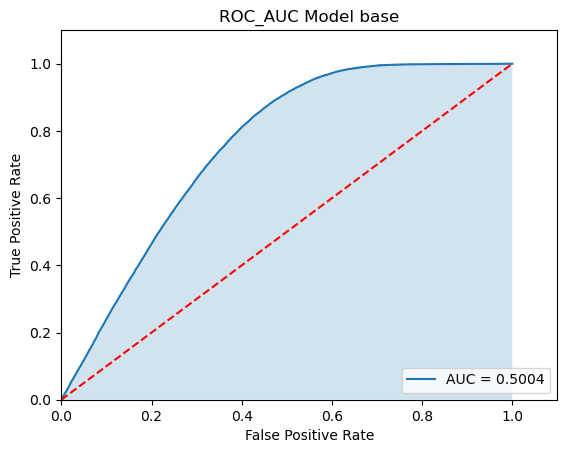

In [160]:
fpr_0, tpr_0, thresholds_0 = plot_AUCROC(lr_0, v_val, v_pred_0, v_pred_prob_0,'ROC_AUC Model base')

In [101]:
#test_copy = test.copy()
# test set
# fit test dataset
y_pred_0 = lr_0.predict(y_train)
y_pred_prob_0 = pd.DataFrame(lr_0.predict_proba(y_train),
                        columns=lr_0.classes_)

test_copy['loan_status_pred_0'] = y_pred_0
test_copy['loan_status_pred_0'].value_counts()
#test.to_csv('test_model.csv')

/Users/dby/opt/anaconda3/envs/itmds2023/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/dby/opt/anaconda3/envs/itmds2023/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0    211626
1         1
Name: loan_status_pred_0, dtype: int64

## Normalization applied for nomalized data 

In [157]:
#trn_X, tst_prep = df_trn(train_ML,test_ML)
#X = trn_X
#v = train_ML[['loan_status_dv']]
#y_train = tst_prep

scale = MinMaxScaler()
Xn = scale.fit_transform(X)

Xn_train, Xn_val, vn_train, vn_val = train_test_split(Xn, v, test_size=0.2, random_state=2)
yn_train = scale.fit_transform(y_train)

In [78]:
# Fit use lr_0 = LogisticRegression(max_iter=1000)
lr_0.fit(Xn_train, np.ravel(vn_train))

# Predict validation 
v_pred_n0 = lr_0.predict(Xn_val)
v_pred_prob_n0 = pd.DataFrame(lr_0.predict_proba(Xn_val),
                        columns=lr_0.classes_)

AUC_score: 0.5530698270846237
Confusion Matrix (Accuracy 0.9319)

       Prediction
Actual      0      1
     0 337620   1234
     1  23654   2917
None
Accuracy: 0.9318930012998563
Precision:   0.7027222356058781
Recall:     0.10978134055925633
Specificity: 0.9963583136099913
F1 SCORE for Default:  0.18989649111385976


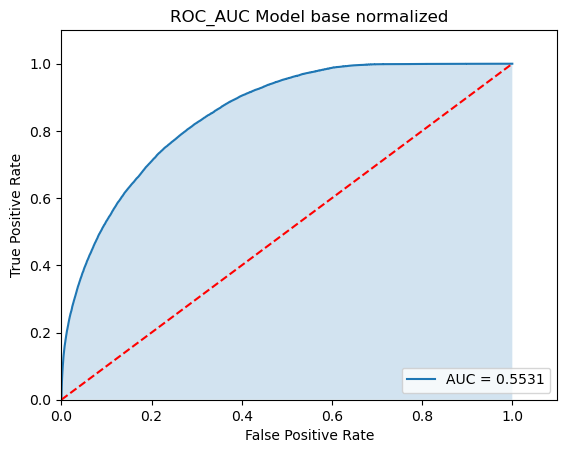

In [100]:
fpr_n0, tpr_n0, thresholds_n0 = plot_AUCROC(lr_0,vn_val, v_pred_n0, v_pred_prob_n0,'ROC_AUC Model base normalized')

In [103]:
#test_copy = test.copy()
# test set
# fit test dataset
y_pred_n0 = lr_0.predict(yn_train)
y_pred_prob_n0 = pd.DataFrame(lr_0.predict_proba(yn_train),
                        columns=lr_0.classes_)

test_copy['loan_status_pred_n0'] = y_pred_n0
test_copy['loan_status_pred_n0'].value_counts()
#test.to_csv('test_model.csv')

0    176159
1     35468
Name: loan_status_pred_n0, dtype: int64

# Logistic Regression - hyperparameter tuning
Use normalized dataset

(solver='newton-cholesky',penalty='l2',max_iter=1000,class_weight='balanced')


Xn_train, Xn_val, vn_train, vn_val = train_test_split(Xn, v, test_size=0.2, random_state=2)

yn_train = scale.fit_transform(y_train)

45 features to train

In [150]:
# Fit 
lr = LogisticRegression(solver='newton-cholesky',penalty='l2',max_iter=1000,class_weight='balanced')
lr.fit(Xn_train, np.ravel(vn_train))

# Predict validation 
v_pred_1 = lr.predict(Xn_val)
v_pred_prob_1 = pd.DataFrame(lr.predict_proba(Xn_val),
                        columns=lr.classes_)

AUC_score: 0.769252008903709
Confusion Matrix (Accuracy 0.7170)

       Prediction
Actual      0      1
     0 239951  98903
     1   4507  22064
None
Accuracy: 0.7170144352466307
Precision:   0.1823968520340258
Recall:     0.8303789846072787
Specificity: 0.7081250332001393
F1 SCORE for Default:  0.29909582616004016


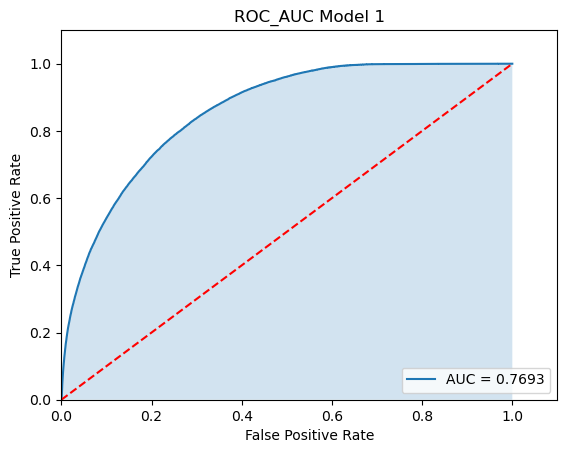

In [151]:
fpr_1, tpr_1, thresholds_1 = plot_AUCROC(lr,vn_val, v_pred_1, v_pred_prob_1,'ROC_AUC Model 1')

In [107]:
#test_copy = test.copy()
# test set
# fit test dataset
y_pred_n0 = lr_0.predict(yn_train)
y_pred_prob_n0 = pd.DataFrame(lr_0.predict_proba(yn_train),
                        columns=lr_0.classes_)

test_copy['loan_status_pred_1'] = y_pred_n0
test_copy['loan_status_pred_1'].value_counts()
#test.to_csv('test_model.csv')

0    176159
1     35468
Name: loan_status_pred_n0, dtype: int64

# Logistic Regression - model 2
Remove more features

Remove similar features and keep top features from model 1

['debt_settlement_flag', 'term', 'num_op_rev_tl', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_il_tl', 'num_bc_tl', 'num_bc_sats', 'num_actv_bc_tl', 'total_bc_limit', 'total_il_high_credit_limit', 'revol_util', 'mo_sin_old_rev_tl_op', 'num_sats', 
                     'acc_open_past_24mths','tot_hi_cred_lim','total_pymnt']

In [144]:
features_drop = ['debt_settlement_flag','term', 'num_op_rev_tl', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_il_tl', 'num_bc_tl', 'num_bc_sats', 'num_actv_bc_tl', 'total_bc_limit', 'total_il_high_credit_limit', 'revol_util', 'mo_sin_old_rev_tl_op', 'num_sats', 
                     'acc_open_past_24mths','tot_hi_cred_lim','total_pymnt']
trn_X_dp, tst_prep_dp = df_trn(train_ML,test_ML,features_drop)
# Split set to create test, validation, test sets
# Drop the columns with NA where at least one element is missing.
X_fdp = trn_X_dp
v_fdp = train_ML[['loan_status_dv']]

scale = MinMaxScaler()
X_fdp = scale.fit_transform(X_fdp)

X_train_fdp, X_val_fdp, v_train_fdp, v_val_fdp = train_test_split(X_fdp, v_fdp, test_size=0.2, random_state=2)
y_train_fdp = tst_prep_dp
y_train_fdp = scale.fit_transform(y_train_fdp)

In [145]:
# Fit 
lr_2 = LogisticRegression(solver='newton-cholesky',penalty='l2',max_iter=1000,class_weight='balanced')
lr_2.fit(X_train_fdp, np.ravel(v_train_fdp))

# Predict validation 
v_pred_2 = lr_2.predict(X_val_fdp)
v_pred_prob_2 = pd.DataFrame(lr_2.predict_proba(X_val_fdp),
                        columns=lr_2.classes_)

AUC_score: 0.7516603421605681
Confusion Matrix (Accuracy 0.6932)

       Prediction
Actual      0      1
     0 231536 107318
     1   4782  21789
None
Accuracy: 0.6932339057262092
Precision:   0.16876699172004617
Recall:     0.8200293553121825
Specificity: 0.6832913290089537
F1 SCORE for Default:  0.2799239455799792


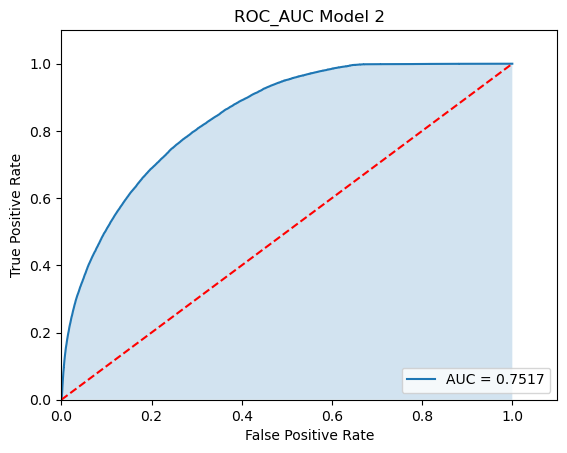

In [146]:
fpr_2, tpr_2, thresholds_2 = plot_AUCROC(lr_2,v_val_fdp, v_pred_2, v_pred_prob_2,'ROC_AUC Model 2')

In [147]:
#test_copy = test.copy()
# test set
# fit test dataset
y_pred_2 = lr_2.predict(y_train_fdp)
y_pred_prob_2 = pd.DataFrame(lr_2.predict_proba(y_train_fdp),
                        columns=lr_2.classes_)

test_copy['loan_status_pred_2'] = y_pred_2
test_copy['loan_status_pred_2'].value_counts()
#test.to_csv('test_model.csv')

0    164574
1     47053
Name: loan_status_pred_2, dtype: int64

In [148]:
print(f'tst_prep_dp features: {tst_prep_dp .shape[1]}')
print(f'trn_X_dp features: {trn_X_dp.shape[1]}')

tst_prep_dp features: 44
trn_X_dp features: 44


# Logistic Regression - model 3
(solver='saga',penalty='l1',max_iter=1000,class_weight='balanced')

In [152]:
# Fit 
lr_3 = LogisticRegression(solver='saga',penalty='l1',max_iter=1000,class_weight='balanced')
lr_3.fit(Xn_train, np.ravel(vn_train))

# Predict validation 
v_pred_3 = lr_3.predict(Xn_val)
v_pred_prob_3 = pd.DataFrame(lr_3.predict_proba(Xn_val),
                        columns=lr_3.classes_)

AUC_score: 0.7700642155431277
Confusion Matrix (Accuracy 0.7192)

       Prediction
Actual      0      1
     0 240782  98072
     1   4529  22042
None
Accuracy: 0.7192282958199356
Precision:   0.18350899978353896
Recall:     0.829551014263671
Specificity: 0.7105774168225844
F1 SCORE for Default:  0.30053516037768


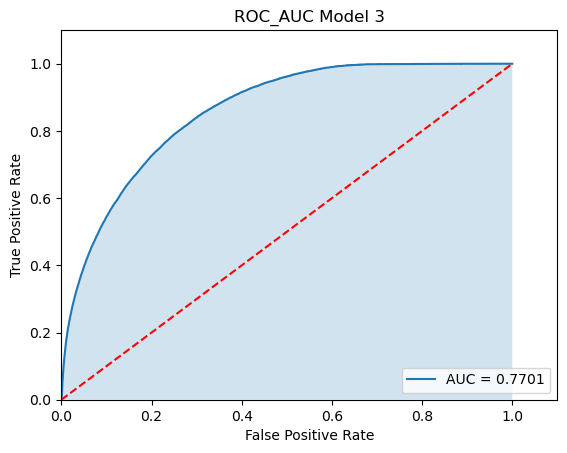

In [159]:
fpr_3, tpr_3, thresholds_3 = plot_AUCROC(lr_3,vn_val, v_pred_3, v_pred_prob_3,'ROC_AUC Model 3')

In [158]:
# test_copy = test.copy()
# test set
# fit test dataset
y_pred_3 = lr_3.predict(yn_train)
y_pred_prob_3 = pd.DataFrame(lr_3.predict_proba(yn_train),
                        columns=lr_3.classes_)

test_copy['loan_status_pred_3'] = y_pred_3
test_copy['loan_status_pred_3'].value_counts()
test.to_csv('test_model.csv')

0    120814
1     90813
Name: loan_status_pred_3, dtype: int64

# Score summary

AUC_score: 0.5004228876888006
Confusion Matrix (Accuracy 0.9270)

       Prediction
Actual      0      1
     0 338707    147
     1  26537     34
None
Accuracy: 0.9269781760963262
Precision:   0.1878453038674033
Recall:     0.0012795905310300703
Specificity: 0.9995661848465711
F1 SCORE for Default:  0.002541866028708134
AUC_score: 0.5530698270846237
Confusion Matrix (Accuracy 0.9319)

       Prediction
Actual      0      1
     0 337620   1234
     1  23654   2917
None
Accuracy: 0.9318930012998563
Precision:   0.7027222356058781
Recall:     0.10978134055925633
Specificity: 0.9963583136099913
F1 SCORE for Default:  0.18989649111385976
AUC_score: 0.769252008903709
Confusion Matrix (Accuracy 0.7170)

       Prediction
Actual      0      1
     0 239951  98903
     1   4507  22064
None
Accuracy: 0.7170144352466307
Precision:   0.1823968520340258
Recall:     0.8303789846072787
Specificity: 0.7081250332001393
F1 SCORE for Default:  0.29909582616004016
AUC_score: 0.7516603421605681
Confusion

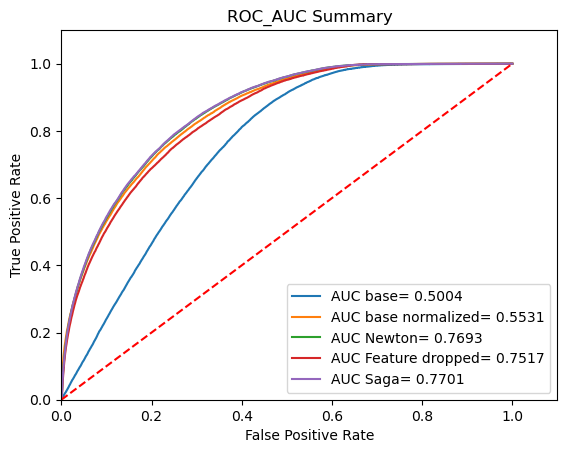

In [175]:
%matplotlib inline

fpr = [fpr_0, fpr_n0, fpr_1, fpr_2, fpr_3];
tpr = [tpr_0, tpr_n0, tpr_1, tpr_2, tpr_3];

AUC_score_0 =score(lr_0, v_val, v_pred_0);
AUC_score_n0 =score(lr_0,vn_val, v_pred_n0);
AUC_score_1 =score(lr,vn_val, v_pred_1);
AUC_score_2 =score(lr_2,vn_val, v_pred_2);
AUC_score_3 =score(lr_3,vn_val, v_pred_3);
AUC_score = [AUC_score_0,AUC_score_n0,AUC_score_1,AUC_score_2,AUC_score_3];

label = ['base','base normalized', 'Newton', 'Feature dropped', 'Saga'];

for i, element in enumerate(fpr):
    plt.plot(fpr[i],tpr[i], label = f'AUC {label[i]}= %0.4f' % AUC_score[i])
plt.title('ROC_AUC Summary')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#fpr_n0, tpr_n0, thresholds_n0 = plot_AUCROC(lr_0,vn_val, v_pred_n0, v_pred_prob_n0,'ROC_AUC Model base normalized')
#fpr_0, tpr_0, thresholds_0 = plot_AUCROC(lr_0, v_val, v_pred_0, v_pred_prob_0,'ROC_AUC Model base')
#fpr_1, tpr_1, thresholds_1 = plot_AUCROC(lr,vn_val, v_pred_1, v_pred_prob_1,'ROC_AUC Model 1')
#fpr_2, tpr_2, thresholds_2 = plot_AUCROC(lr_2,v_val_fdp, v_pred_2, v_pred_prob_2,'ROC_AUC Model 2')
#fpr_3, tpr_3, thresholds_3 = plot_AUCROC(lr_3,vn_val, v_pred_3, v_pred_prob_3,'ROC_AUC Model 3')

# Export results

In [181]:
# test.to_csv('test_model.csv')